## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
#from keras.layers import LSTM
#from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import pandas as pd

/home/stjepan/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data

In [24]:
# FEATURES npy (audiofiles in array format):
# https://drive.google.com/file/d/1L2pQ-tyKJ80pJpG8HtXqyAfrvLuvY7Wn/view?usp=sharing

# LABELS cvs:
# https://drive.google.com/open?id=1SE8BFFR-uXUQaMGe-F0cs2a-jpyHTP2m


In [25]:
features = np.load('/home/stjepan/Downloads/training.npy') #loading features data


In [26]:
features[0][0,:].shape   #shape of one sample corresponds to sampling rate*duration (frequency*time)


(110250,)

In [27]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(features):
        mfccs = np.mean(librosa.feature.mfcc(y[0,:], 
                                            sr=44100, #actual sample-rate (checked with audio editor "Audacity")
                                            n_mfcc=26),
                                            axis=0)
        feature = mfccs
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1 
        


In [5]:
df.head(5)

,feature
0,"[5.735180083416181, 4.689635877045118, 2.26977..."
1,"[-2.8083581662585098, -4.742628822073273, -11...."
2,"[0.956286887375573, -1.2995481060617229, -0.31..."
3,"[2.072625571861468, 0.6307368289330955, 1.7738..."
4,"[-1.5676855037213036, -3.9132820767986596, -8...."


In [9]:
df3 = pd.DataFrame(df['feature'].values.tolist()) #Unpacking features

In [10]:
df3.head() #number of columns/features corresponds to mfccs.shape 

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,5.735180,4.689636,2.269777,0.578810,-0.510475,6.298124,7.047494,6.099302,7.664116,7.341090,...,-3.320609,-3.021116,-4.349071,-7.386942,-14.625562,-19.783721,-19.783721,-19.783721,-19.783721,-19.783721
1,-2.808358,-4.742629,-11.271379,-11.618718,-14.015418,-13.524512,-12.914274,-13.424393,-11.692038,-11.125215,...,-20.139208,-20.697500,-21.332812,-21.778720,-22.674451,-22.674451,-22.674451,-22.674451,-22.674451,-22.674451
2,0.956287,-1.299548,-0.316097,1.300920,-0.926437,-0.273497,0.220382,-0.284960,1.519507,1.908047,...,-8.889242,-9.406684,-12.490580,-15.727586,-19.405516,-19.865301,-19.865301,-19.865301,-19.865301,-19.865301
3,2.072626,0.630737,1.773860,3.266194,1.111679,2.712303,3.195792,2.441174,4.222577,4.236691,...,-6.096858,-6.674362,-9.878371,-13.171009,-18.957325,-19.794864,-19.794864,-19.794864,-19.794864,-19.794864
4,-1.567686,-3.913282,-8.287329,-7.087222,-9.345885,-8.948632,-8.396338,-8.891746,-7.076136,-6.509135,...,-16.574802,-17.244952,-19.034728,-19.793534,-21.046743,-21.046743,-21.046743,-21.046743,-21.046743,-21.046743


In [28]:
labels = pd.read_csv("/home/stjepan/Downloads/overdrive_gain_y.csv")  #reading labels from csv

In [29]:
labels.drop(columns="Unnamed: 0", inplace=True)

In [53]:
labels.gain.describe() #describing labels

count    1000.00000
mean       37.97700
std        21.98408
min         0.00000
25%        19.00000
50%        38.00000
75%        58.00000
max        75.00000
Name: gain, dtype: float64

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbb5ef77400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbb5eea3b38>)

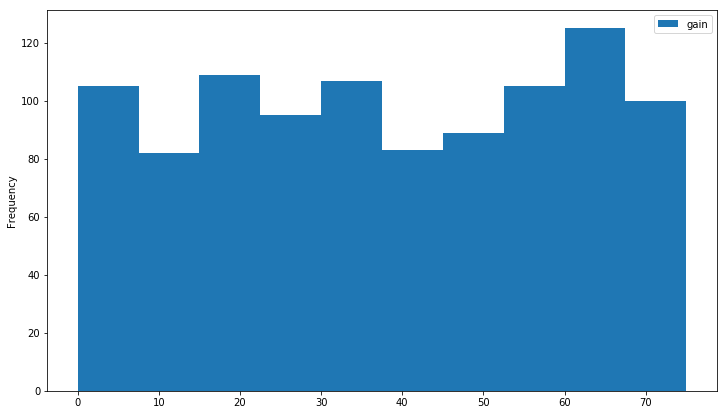

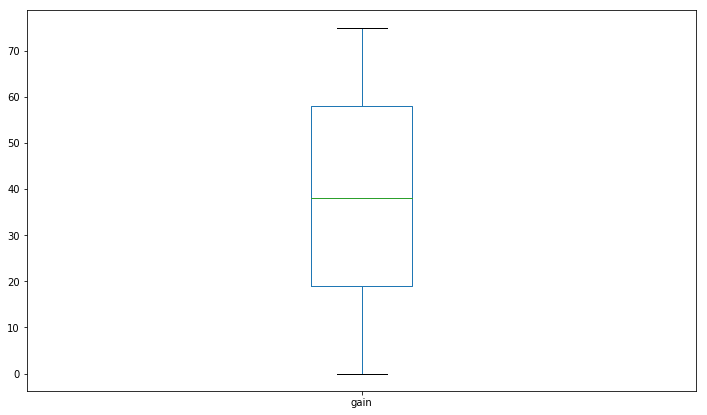

In [57]:
labels.plot.hist(), labels.plot.box() #plotting distribution of labels

#### Concatenating features and labels

In [31]:
newdf = pd.concat([df3,labels], axis=1)

In [32]:
type(newdf.gain[0])

numpy.int64

In [33]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [34]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,gain
0,5.735180,4.689636,2.269777,0.578810,-0.510475,6.298124,7.047494,6.099302,7.664116,7.341090,...,-3.021116,-4.349071,-7.386942,-14.625562,-19.783721,-19.783721,-19.783721,-19.783721,-19.783721,74
1,-2.808358,-4.742629,-11.271379,-11.618718,-14.015418,-13.524512,-12.914274,-13.424393,-11.692038,-11.125215,...,-20.697500,-21.332812,-21.778720,-22.674451,-22.674451,-22.674451,-22.674451,-22.674451,-22.674451,22
2,0.956287,-1.299548,-0.316097,1.300920,-0.926437,-0.273497,0.220382,-0.284960,1.519507,1.908047,...,-9.406684,-12.490580,-15.727586,-19.405516,-19.865301,-19.865301,-19.865301,-19.865301,-19.865301,54
3,2.072626,0.630737,1.773860,3.266194,1.111679,2.712303,3.195792,2.441174,4.222577,4.236691,...,-6.674362,-9.878371,-13.171009,-18.957325,-19.794864,-19.794864,-19.794864,-19.794864,-19.794864,61
4,-1.567686,-3.913282,-8.287329,-7.087222,-9.345885,-8.948632,-8.396338,-8.891746,-7.076136,-6.509135,...,-17.244952,-19.034728,-19.793534,-21.046743,-21.046743,-21.046743,-21.046743,-21.046743,-21.046743,34


### Shuffling the data

In [35]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,gain
627,-3.077418,-4.625148,-10.057366,-12.082321,-12.065376,-11.485250,-10.948367,-11.299882,-12.073430,-11.932857,...,-15.907490,-16.116261,-16.590189,-16.923300,-17.407986,-17.876385,-18.599211,-19.123925,-19.423425,24
859,-2.147701,-1.050856,-2.471295,-3.480038,-2.741667,-2.998793,-3.831970,-3.586098,-4.419711,-4.025918,...,-20.248387,-20.248387,-20.248387,-20.248387,-20.248387,-20.248387,-20.248387,-20.248387,-20.248387,50
183,-3.160452,-5.061046,-11.369608,-17.489547,-19.950472,-19.958474,-19.950089,-19.963837,-20.029785,-20.089489,...,-12.026095,-12.476077,-12.928337,-13.498187,-13.881254,-14.364007,-14.855868,-15.580294,-15.142772,7
287,-3.483913,-5.335141,-11.897933,-17.334962,-17.372132,-17.125968,-17.131464,-16.977194,-16.733437,-16.684193,...,-24.865757,-24.407469,-24.682125,-24.905358,-25.776908,-25.977262,-25.743741,-25.418638,-24.953665,7
783,-3.262506,-5.191258,-11.110677,-13.364110,-14.199520,-16.128684,-16.546096,-16.285561,-16.313318,-16.706119,...,-21.244146,-21.313929,-21.435281,-21.609375,-21.735842,-21.870852,-22.068849,-22.101874,-21.724975,15
684,-3.577422,-2.118737,-2.658664,-2.141338,-2.279383,-1.830943,-2.068695,-2.288276,-2.152554,-2.622476,...,-7.007425,-6.841180,-6.126606,-6.332572,-6.346440,-7.035433,-7.542101,-8.314391,-8.378621,45
921,-4.045059,-6.089836,-13.052443,-20.230415,-22.806438,-21.749221,-20.072231,-19.190088,-18.969795,-20.440692,...,-26.802838,-26.802838,-26.802838,-26.802838,-26.802838,-26.802838,-26.802838,-26.802838,-26.802838,5
148,-2.194403,-3.689363,-9.083137,-10.026745,-8.844546,-9.418656,-7.960221,-8.193927,-8.088191,-8.742949,...,-11.007694,-11.861265,-12.556897,-13.374408,-14.337536,-15.274429,-16.504829,-16.560212,-18.587704,41
481,-3.439649,-4.932618,-6.153124,-6.483432,-2.992393,-2.613549,-2.117446,-0.852412,-2.192568,-3.992561,...,-10.314863,-11.918377,-12.262282,-10.761574,-11.302598,-13.543436,-14.654511,-16.672092,-17.248373,42
772,-0.691020,-2.074375,-1.805447,-1.449459,-0.598429,1.453093,1.741763,0.660906,0.343762,0.330110,...,-11.936338,-12.807904,-12.810498,-11.313832,-10.898346,-10.644399,-11.013895,-11.542792,-9.487323,59


In [36]:
rnewdf=rnewdf.fillna(0)

### Train/test split

In [37]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [38]:
trainfeatures = train.iloc[:, :-1]

trainlabel = train.iloc[:, -1:]

testfeatures = test.iloc[:, :-1]

testlabel = test.iloc[:, -1:]

In [39]:
from keras.utils import np_utils #not sure if this is necessary

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

### Pading inputs for CNN 

In [40]:
#the shape has to correspond to (nrows, nfeatures, 1)

print('Pad sequences')
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

Pad sequences


In [41]:
x_traincnn.shape, x_testcnn.shape

((791, 216, 1), (209, 216, 1))

## CNN model

In [42]:
model = Sequential()

model.add(Conv1D(128, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(1))

opt = keras.optimizers.adam(lr=0.0001)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


There is a lot room for hyperparameter modification, so don't hesitate to change them

In [43]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 216, 128)          768       
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 216, 128)          82048     
_________________________________________________________________
activation_2 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           82048     
__________

##### Model compiling

In [44]:
model.compile(loss='mse', optimizer=opt, metrics=['mse', 'mae']) #selecting loss fn and metrics

### Model fitting

In [45]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=400, validation_data=(x_testcnn, y_test))

Train on 791 samples, validate on 209 samples
Epoch 1/400
791/791 [==============================] - 4s 5ms/step - loss: 662.0729 - mean_squared_error: 662.0729 - mean_absolute_error: 19.2741 - val_loss: 72.6653 - val_mean_squared_error: 72.6653 - val_mean_absolute_error: 7.0308
Epoch 2/400
791/791 [==============================] - 3s 4ms/step - loss: 53.1771 - mean_squared_error: 53.1771 - mean_absolute_error: 5.7036 - val_loss: 69.0646 - val_mean_squared_error: 69.0646 - val_mean_absolute_error: 6.8804
Epoch 3/400
791/791 [==============================] - 3s 3ms/step - loss: 37.0181 - mean_squared_error: 37.0181 - mean_absolute_error: 4.7333 - val_loss: 59.7656 - val_mean_squared_error: 59.7656 - val_mean_absolute_error: 6.3301
Epoch 4/400
791/791 [==============================] - 3s 3ms/step - loss: 31.6890 - mean_squared_error: 31.6890 - mean_absolute_error: 4.2275 - val_loss: 25.5101 - val_mean_squared_error: 25.5101 - val_mean_absolute_error: 3.8696
Epoch 5/400
791/791 [======

Epoch 72/400
791/791 [==============================] - 3s 3ms/step - loss: 7.1338 - mean_squared_error: 7.1338 - mean_absolute_error: 2.0927 - val_loss: 69.5969 - val_mean_squared_error: 69.5969 - val_mean_absolute_error: 7.1069
Epoch 73/400
791/791 [==============================] - 3s 3ms/step - loss: 12.7518 - mean_squared_error: 12.7518 - mean_absolute_error: 2.8215 - val_loss: 40.8408 - val_mean_squared_error: 40.8408 - val_mean_absolute_error: 5.6673
Epoch 74/400
791/791 [==============================] - 3s 3ms/step - loss: 5.2283 - mean_squared_error: 5.2283 - mean_absolute_error: 1.8126 - val_loss: 12.5927 - val_mean_squared_error: 12.5927 - val_mean_absolute_error: 3.0662
Epoch 75/400
791/791 [==============================] - 3s 3ms/step - loss: 4.0305 - mean_squared_error: 4.0305 - mean_absolute_error: 1.5559 - val_loss: 24.6302 - val_mean_squared_error: 24.6302 - val_mean_absolute_error: 4.2821
Epoch 76/400
791/791 [==============================] - 3s 3ms/step - loss: 3.

Epoch 108/400
791/791 [==============================] - 3s 3ms/step - loss: 2.6586 - mean_squared_error: 2.6586 - mean_absolute_error: 1.2570 - val_loss: 32.5921 - val_mean_squared_error: 32.5921 - val_mean_absolute_error: 4.8419
Epoch 109/400
791/791 [==============================] - 3s 3ms/step - loss: 3.1559 - mean_squared_error: 3.1559 - mean_absolute_error: 1.3724 - val_loss: 7.3133 - val_mean_squared_error: 7.3133 - val_mean_absolute_error: 2.2462
Epoch 110/400
791/791 [==============================] - 3s 3ms/step - loss: 3.7326 - mean_squared_error: 3.7326 - mean_absolute_error: 1.4688 - val_loss: 19.6989 - val_mean_squared_error: 19.6989 - val_mean_absolute_error: 3.7967
Epoch 111/400
791/791 [==============================] - 3s 3ms/step - loss: 4.4279 - mean_squared_error: 4.4279 - mean_absolute_error: 1.5768 - val_loss: 16.6272 - val_mean_squared_error: 16.6272 - val_mean_absolute_error: 3.4224
Epoch 112/400
791/791 [==============================] - 3s 3ms/step - loss: 4

Epoch 179/400
791/791 [==============================] - 3s 3ms/step - loss: 1.5398 - mean_squared_error: 1.5398 - mean_absolute_error: 0.9709 - val_loss: 5.9257 - val_mean_squared_error: 5.9257 - val_mean_absolute_error: 1.9576
Epoch 180/400
791/791 [==============================] - 3s 3ms/step - loss: 1.4171 - mean_squared_error: 1.4171 - mean_absolute_error: 0.9240 - val_loss: 14.4324 - val_mean_squared_error: 14.4324 - val_mean_absolute_error: 3.0960
Epoch 181/400
791/791 [==============================] - 3s 3ms/step - loss: 1.6054 - mean_squared_error: 1.6054 - mean_absolute_error: 0.9664 - val_loss: 16.1098 - val_mean_squared_error: 16.1098 - val_mean_absolute_error: 3.2519
Epoch 182/400
791/791 [==============================] - 3s 3ms/step - loss: 2.1174 - mean_squared_error: 2.1174 - mean_absolute_error: 1.1165 - val_loss: 8.4698 - val_mean_squared_error: 8.4698 - val_mean_absolute_error: 2.4073
Epoch 183/400
791/791 [==============================] - 3s 3ms/step - loss: 1.5

Epoch 215/400
791/791 [==============================] - 3s 3ms/step - loss: 2.4325 - mean_squared_error: 2.4325 - mean_absolute_error: 1.1851 - val_loss: 19.5154 - val_mean_squared_error: 19.5154 - val_mean_absolute_error: 3.5125
Epoch 216/400
791/791 [==============================] - 3s 3ms/step - loss: 1.6177 - mean_squared_error: 1.6177 - mean_absolute_error: 0.9872 - val_loss: 14.4187 - val_mean_squared_error: 14.4187 - val_mean_absolute_error: 3.2164
Epoch 217/400
791/791 [==============================] - 3s 3ms/step - loss: 2.0076 - mean_squared_error: 2.0076 - mean_absolute_error: 1.0949 - val_loss: 18.4379 - val_mean_squared_error: 18.4379 - val_mean_absolute_error: 3.5829
Epoch 218/400
791/791 [==============================] - 3s 3ms/step - loss: 1.9321 - mean_squared_error: 1.9321 - mean_absolute_error: 1.0849 - val_loss: 6.3782 - val_mean_squared_error: 6.3782 - val_mean_absolute_error: 2.0840
Epoch 219/400
791/791 [==============================] - 3s 3ms/step - loss: 1

Epoch 251/400
791/791 [==============================] - 3s 4ms/step - loss: 1.8856 - mean_squared_error: 1.8856 - mean_absolute_error: 1.0580 - val_loss: 4.8197 - val_mean_squared_error: 4.8197 - val_mean_absolute_error: 1.7788
Epoch 252/400
791/791 [==============================] - 3s 3ms/step - loss: 1.7610 - mean_squared_error: 1.7610 - mean_absolute_error: 1.0385 - val_loss: 7.9502 - val_mean_squared_error: 7.9502 - val_mean_absolute_error: 2.2557
Epoch 253/400
791/791 [==============================] - 3s 3ms/step - loss: 1.2881 - mean_squared_error: 1.2881 - mean_absolute_error: 0.8608 - val_loss: 10.1636 - val_mean_squared_error: 10.1636 - val_mean_absolute_error: 2.5112
Epoch 254/400
791/791 [==============================] - 3s 3ms/step - loss: 1.5329 - mean_squared_error: 1.5329 - mean_absolute_error: 0.9386 - val_loss: 12.0720 - val_mean_squared_error: 12.0720 - val_mean_absolute_error: 2.8399
Epoch 255/400
791/791 [==============================] - 3s 3ms/step - loss: 2.0

Epoch 287/400
791/791 [==============================] - 3s 3ms/step - loss: 2.2384 - mean_squared_error: 2.2384 - mean_absolute_error: 1.1499 - val_loss: 5.0838 - val_mean_squared_error: 5.0838 - val_mean_absolute_error: 1.7700
Epoch 288/400
791/791 [==============================] - 3s 3ms/step - loss: 1.8264 - mean_squared_error: 1.8264 - mean_absolute_error: 1.0289 - val_loss: 4.8147 - val_mean_squared_error: 4.8147 - val_mean_absolute_error: 1.7806
Epoch 289/400
791/791 [==============================] - 3s 4ms/step - loss: 1.5641 - mean_squared_error: 1.5641 - mean_absolute_error: 0.9768 - val_loss: 3.9541 - val_mean_squared_error: 3.9541 - val_mean_absolute_error: 1.6561
Epoch 290/400
791/791 [==============================] - 3s 3ms/step - loss: 1.3444 - mean_squared_error: 1.3444 - mean_absolute_error: 0.8836 - val_loss: 4.8967 - val_mean_squared_error: 4.8967 - val_mean_absolute_error: 1.7754
Epoch 291/400
791/791 [==============================] - 3s 4ms/step - loss: 1.1125 

Epoch 323/400
791/791 [==============================] - 3s 3ms/step - loss: 2.3670 - mean_squared_error: 2.3670 - mean_absolute_error: 1.2017 - val_loss: 20.5741 - val_mean_squared_error: 20.5741 - val_mean_absolute_error: 3.6466
Epoch 324/400
791/791 [==============================] - 3s 4ms/step - loss: 1.9768 - mean_squared_error: 1.9768 - mean_absolute_error: 1.0499 - val_loss: 7.4527 - val_mean_squared_error: 7.4527 - val_mean_absolute_error: 2.1196
Epoch 325/400
791/791 [==============================] - 3s 4ms/step - loss: 1.4766 - mean_squared_error: 1.4766 - mean_absolute_error: 0.9480 - val_loss: 6.7063 - val_mean_squared_error: 6.7063 - val_mean_absolute_error: 2.0599
Epoch 326/400
791/791 [==============================] - 3s 4ms/step - loss: 1.1829 - mean_squared_error: 1.1829 - mean_absolute_error: 0.8433 - val_loss: 8.9369 - val_mean_squared_error: 8.9369 - val_mean_absolute_error: 2.3493
Epoch 327/400
791/791 [==============================] - 3s 4ms/step - loss: 1.361

Epoch 359/400
791/791 [==============================] - 3s 3ms/step - loss: 5.6069 - mean_squared_error: 5.6069 - mean_absolute_error: 1.8847 - val_loss: 3.1157 - val_mean_squared_error: 3.1157 - val_mean_absolute_error: 1.3340
Epoch 360/400
791/791 [==============================] - 3s 4ms/step - loss: 4.0250 - mean_squared_error: 4.0250 - mean_absolute_error: 1.5346 - val_loss: 10.7388 - val_mean_squared_error: 10.7388 - val_mean_absolute_error: 2.6535
Epoch 361/400
791/791 [==============================] - 3s 4ms/step - loss: 4.0469 - mean_squared_error: 4.0469 - mean_absolute_error: 1.5855 - val_loss: 3.8142 - val_mean_squared_error: 3.8142 - val_mean_absolute_error: 1.5628
Epoch 362/400
791/791 [==============================] - 3s 4ms/step - loss: 1.8025 - mean_squared_error: 1.8025 - mean_absolute_error: 1.0331 - val_loss: 4.7333 - val_mean_squared_error: 4.7333 - val_mean_absolute_error: 1.6943
Epoch 363/400
791/791 [==============================] - 3s 4ms/step - loss: 1.346

Epoch 395/400
791/791 [==============================] - 3s 4ms/step - loss: 1.2185 - mean_squared_error: 1.2185 - mean_absolute_error: 0.8608 - val_loss: 6.4689 - val_mean_squared_error: 6.4689 - val_mean_absolute_error: 2.0791
Epoch 396/400
791/791 [==============================] - 3s 4ms/step - loss: 0.9394 - mean_squared_error: 0.9394 - mean_absolute_error: 0.7590 - val_loss: 10.5285 - val_mean_squared_error: 10.5285 - val_mean_absolute_error: 2.6195
Epoch 397/400
791/791 [==============================] - 3s 3ms/step - loss: 1.5659 - mean_squared_error: 1.5659 - mean_absolute_error: 0.9752 - val_loss: 7.7487 - val_mean_squared_error: 7.7487 - val_mean_absolute_error: 2.3586
Epoch 398/400
791/791 [==============================] - 3s 4ms/step - loss: 1.2760 - mean_squared_error: 1.2760 - mean_absolute_error: 0.8990 - val_loss: 4.3158 - val_mean_squared_error: 4.3158 - val_mean_absolute_error: 1.6958
Epoch 399/400
791/791 [==============================] - 3s 3ms/step - loss: 1.565

### Plotting results

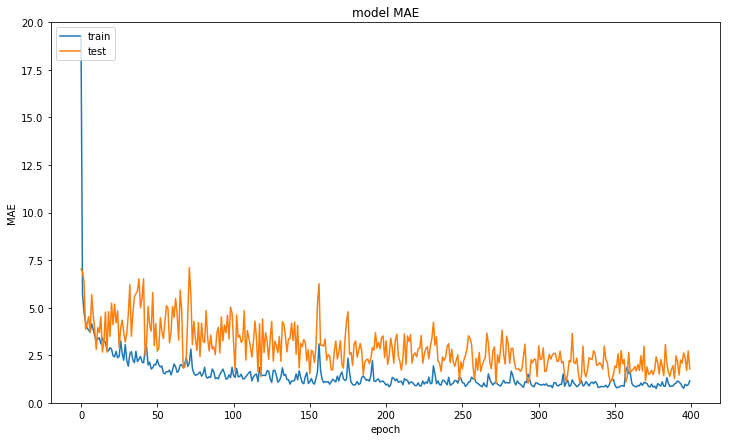

In [46]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 7 #setting figure size


plt.plot(cnnhistory.history['mean_absolute_error'])
plt.plot(cnnhistory.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.ylim(ymax=20)
plt.ylim(ymin=0)
plt.show()

### Saving model

In [47]:
import os
model_name = 'guitar_dist_gain_regression_model_400ep_lr0.0001.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /home/stjepan/Downloads/saved_models/guitar_dist_gain_regression_model_400ep_lr0.0001.h5 


### Predctions

In [52]:
preds = model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)


preds=list(preds[:,0])
actual=list(y_test[:,0])

results = pd.DataFrame({'predicted' : preds, 'actual' : actual})    

results['diff'] = results['predicted'] - results['actual']
print(results['diff'].mean()) 
results.head(15)

209/209 [==============================] - 0s 1ms/step
-1.093804462959892


,predicted,actual,diff
0,41.198730,42,-0.801270
1,43.350414,44,-0.649586
2,27.503122,27,0.503122
3,45.036068,47,-1.963932
4,10.412045,8,2.412045
5,54.074150,57,-2.925850
6,54.554314,57,-2.445686
7,63.445229,66,-2.554771
8,5.702683,2,3.702683
9,68.952522,74,-5.047478


Baseline model predicts gain parameter value of guitar distorstion effect with average error of 1.5 (out of range 0-75)